In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import math
import sys
import statistics
import os

%matplotlib inline
from ipywidgets import interactive, interact_manual

import warnings
warnings.filterwarnings('ignore')

## make the first row of the df, the second row, spectrum cell is wavenumber, from 3rd row on, spetrum is uv data|

In [2]:
spectra_dir = './'

SampleName="4025-12__PL2024_03_12_1120.csv"

# Enter PL spectra path (Input)
pathPLspectra=os.path.join(spectra_dir, SampleName)


df = pd.read_csv(pathPLspectra, sep=";", skiprows=10, index_col=None, header=0)
df
wavenumber = [float(num) for num in df.iloc[1][0].split(',')][1:] # attention, the first number in the plot is strange, need to be removed !!!
df.at[1, 'spectrum'] = np.array(wavenumber) # move wavenumber to the column of spectrum

for i in range(2, len(df)):
    uv_data = [float(num) for num in df['spectrum'][i].split(',')][1:]
    df.at[i, 'spectrum'] = np.array(uv_data)

In [32]:
meta_data = pd.read_csv(pathPLspectra, nrows=2, sep=";", header=None)
lab_id = meta_data.iloc[1].str.split(";").str[1].values[0]
print(lab_id)

 4025-12


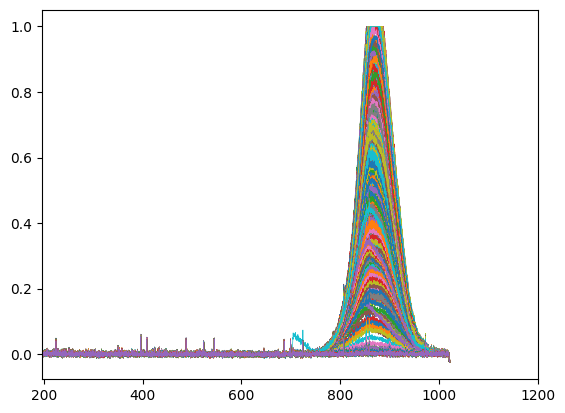

In [4]:
#Check the spectra
fig, ax=plt.subplots()
for i in range(3,len(df)):
    uv_data = df.at[i, 'spectrum']
    ax.plot(wavenumber, uv_data, linewidth=0.5)
    ax.set_xlim([min(wavenumber), 1200])

## clean data: remove the data that intensity exceed max ??

## PLQY/integral_pl

In [5]:
## todo plqy is from wavenumber intensity
## for PLQY, later on we need to calculte the absolute photons. 

integral_pl = pd.DataFrame(index=df.columns, columns=['Intgral'])
areas={}

print(integral_pl.columns)
x_values = df.at[1, 'spectrum']
for i in range(2, len(df)):
    y_values = df.at[i, 'spectrum']
 
    fit_range_mask = (x_values >= 700.0) & (x_values <= 980.0) # change range according to pl spectra
    x_range = x_values[fit_range_mask]
    y_range = y_values[fit_range_mask]
    area = np.trapz(y_range, x_range)
    df.at[i, 'integral_pl'] = area
df

Index(['Intgral'], dtype='object')


,x,y,z,neutral_density,power_transmitted,int_time_PL_sample,spectrum,integral_pl
0,0.0,1.0,0.0,0.0,1.0,0.5,195.43841965,NaN
1,"3039,195.64053147108308,195.84265837622405,196...",NaN,NaN,NaN,NaN,NaN,"[195.64053147108308, 195.84265837622405, 196.0...",NaN
2,0.0,1.0,0.0,0.0,1.0,0.5,"[0.01042482138079339, 0.009949164131479626, 0....",31.146836
3,2.0,1.0,0.0,0.0,1.0,0.5,"[0.00833624593784626, 0.008603957671800286, 0....",13.911463
4,4.0,1.0,0.0,0.0,1.0,0.5,"[0.007934225272491085, 0.008172252030665817, 0...",16.250701
...,...,...,...,...,...,...,...,...
573,8.0,47.0,0.0,0.0,1.0,0.5,"[0.009273152499832557, 0.006475582021145431, 0...",-0.128223
574,6.0,47.0,0.0,0.0,1.0,0.5,"[0.008010386495573634, 0.0067616284399692125, ...",0.167830
575,4.0,47.0,0.0,0.0,1.0,0.5,"[0.010573089206720721, 0.006675130427882769, 0...",-0.063327
576,2.0,47.0,0.0,0.0,1.0,0.5,"[0.006329835483759005, 0.0094526204130998, 0.0...",0.090885


In [6]:
#variables
h = 6.62607004e-34     # m^2 kg s^-1    , planck constant
c = 2.99792458e8       # m s^-1         , speed of light
q = 1.6021766208e-19   # joule          , eV to joule
hc = 1239.84198        # eV nm          , planck constant times speed of light in eV


#laser_flux = 5.42e21   # photons m^-2 s^-1
kt_at_RT = 25.7        # meV



# add energy scale x, y

In [7]:
df['spectrum_energy'] = pd.Series([None] * len(df), dtype=object)
energy=hc/np.array(wavenumber)
df.at[1, 'spectrum_energy'] = energy

In [8]:
# jocobian transformation
# intensity_energy_scale = hc * y / energy**2
df.loc[2:, 'spectrum_energy'] = df.loc[2:].apply(lambda row: hc * row['spectrum'] / energy**2, axis=1)

## peak_pos, FWHM

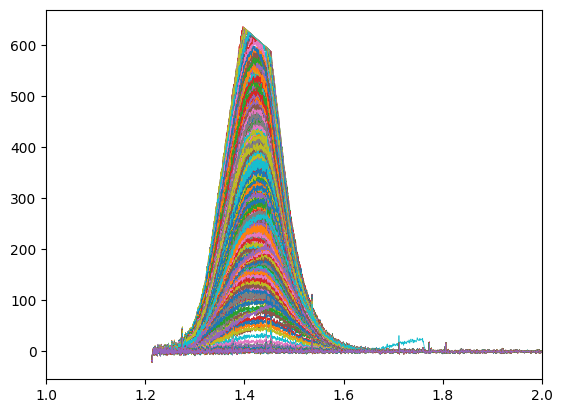

In [9]:
fig, ax=plt.subplots()
for i in range(3, len(df)):
    pl_energy_data = df.at[i, 'spectrum_energy']
    ax.plot(energy, pl_energy_data, linewidth=0.5)
    ax.set_xlim([1, 2]) 

In [10]:
# to visualize measured data, to check for anormalities.
## to check & visiaulize gaussian fit
# todo why the peak is not the real peak as shown in the plot ?

# Define the Gaussian function
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) / (2 * stddev))**2)

# Function to fit Gaussian and plot
def plotRTA(spectra_number, fit_gaussian=True):
    # Extract x and y data
    x_data = df.at[1, 'spectrum_energy']
    y_data = df.at[spectra_number, 'spectrum_energy']

 
    uv_data = df.at[i, 'spectrum_energy']
    ax.plot(x_data, uv_data, linewidth=0.5)
        # ax.set_xlim([min(wavenumber), 1200]) 

    
    # Plotfit_gaussian original data
    plt.plot(x_data, y_data, label="Original Data")
    plt.axvline(x=1.47 ,color="red",linestyle=':', linewidth=2, label="Peak=1.47 eV")
    # Fit Gaussian if requested
    if fit_gaussian:
        # Restricting fit range between 1.2 and 1.5 eV
        fit_range_mask = (x_data >= 1.2) & (x_data <= 1.75)
        x_fit = x_data[fit_range_mask]
        y_fit = y_data[fit_range_mask]
        
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit)
            y_fit = gaussian(x_fit, *popt)
            plt.plot(x_fit, y_fit, label="Gaussian Fit")
        except RuntimeError:
            print("Error - curve_fit failed.")
            
    
    
    # Set plot parameters
    plt.xlabel("PL Energy (eV)") 
    plt.ylabel("Intensity")
    plt.xlim(1,3)
    #plt.ylim(-0.025,0.2)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=20, title_fontsize=18)
    plt.grid(True)
    
    plt.show()

# Create interactive plot
interactive_plot = interactive(plotRTA, spectra_number=(2, len(df)-1), fit_gaussian=True)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot    

interactive(children=(IntSlider(value=289, description='spectra_number', max=577, min=2), Checkbox(value=True,…

In [11]:
#Gaussian fit for PL
#change range for different bandgaps

class PL_funcs:
    def __init__(self, data):
        self.data = data
    
    @staticmethod
    def gaussian(xg, amp, mean, stddev):
        return amp * np.exp(-((xg - mean) / (2 * stddev))**2)
    
    def fit_gaussian(self, x_data, y_data):
        # Restricting fit range between 1.2 and 1.5 eV
        fit_range_mask = (x_data >= 1.2) & (x_data <= 1.75)
        x_fit = x_data[fit_range_mask]
        y_fit = y_data[fit_range_mask]
        
        try:
            popt, pcov = curve_fit(self.gaussian, x_fit, y_fit)
            return popt
        except RuntimeError:
            return None

    def find_peak(self, x_data, y_data):
        popt = self.fit_gaussian(x_data, y_data)
        if popt is not None:
            peak_pos = popt[1]  # mean of the Gaussian is the peak position
            return peak_pos
        else:
            return None



In [12]:
from scipy.optimize import curve_fit
pl_analyzer = PL_funcs(df)

columns = []
peak_positions = []

x_data = df.at[1, 'spectrum_energy'] # energy
for i in range(2, len(df)):
    y_data = df.at[i, 'spectrum_energy']
    # to find peak position
    popt = pl_analyzer.fit_gaussian(x_data, y_data)
       
 
    if popt is not None:
        A_fit, mu_fit, sigma_fit = popt # which should be used for max peak ?
        FWHM_fit = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
        df.at[i, 'peak_pos'] = mu_fit
        df.at[i, 'FWHM'] = FWHM_fit
    else:
        print(f"Error - curve_fit failed for row {i}.")
        df.at[i, 'peak_pos'] = np.nan
        df.at[i, 'FWHM'] = np.nan        

df.at[556, 'peak_pos']

Error - curve_fit failed for row 556.
Error - curve_fit failed for row 561.
Error - curve_fit failed for row 564.
Error - curve_fit failed for row 569.
Error - curve_fit failed for row 576.


nan

In [13]:
df

,x,y,z,neutral_density,power_transmitted,int_time_PL_sample,spectrum,integral_pl,spectrum_energy,peak_pos,FWHM
0,0.0,1.0,0.0,0.0,1.0,0.5,195.43841965,NaN,None,NaN,NaN
1,"3039,195.64053147108308,195.84265837622405,196...",NaN,NaN,NaN,NaN,NaN,"[195.64053147108308, 195.84265837622405, 196.0...",NaN,"[6.3373472290084045, 6.330806527443057, 6.3242...",NaN,NaN
2,0.0,1.0,0.0,0.0,1.0,0.5,"[0.01042482138079339, 0.009949164131479626, 0....",31.146836,"[0.3218251299366863, 0.3077760698710393, 0.188...",1.383763,-0.109426
3,2.0,1.0,0.0,0.0,1.0,0.5,"[0.00833624593784626, 0.008603957671800286, 0....",13.911463,"[0.2573486234569295, 0.26616228685832816, 0.13...",1.454790,-0.132881
4,4.0,1.0,0.0,0.0,1.0,0.5,"[0.007934225272491085, 0.008172252030665817, 0...",16.250701,"[0.2449378254068515, 0.2528075302361993, 0.123...",1.449596,-0.125877
...,...,...,...,...,...,...,...,...,...,...,...
573,8.0,47.0,0.0,0.0,1.0,0.5,"[0.009273152499832557, 0.006475582021145431, 0...",-0.128223,"[0.2862719080903999, 0.2003212690289894, 0.155...",1.213307,0.001308
574,6.0,47.0,0.0,0.0,1.0,0.5,"[0.008010386495573634, 0.0067616284399692125, ...",0.167830,"[0.24728900195169248, 0.20917007697132817, 0.1...",3.293435,-0.264614
575,4.0,47.0,0.0,0.0,1.0,0.5,"[0.010573089206720721, 0.006675130427882769, 0...",-0.063327,"[0.3264023126625607, 0.2064942724655617, 0.131...",1.213226,-0.001351
576,2.0,47.0,0.0,0.0,1.0,0.5,"[0.006329835483759005, 0.0094526204130998, 0.0...",0.090885,"[0.1954086360454796, 0.2924155559482111, 0.159...",NaN,NaN


In [14]:
# check ln or log ?
import math
df.loc[2:, 'voc'] = df.loc[2:].apply(lambda row: 0.932 * row['peak_pos'] + kt_at_RT * math.log(row['integral_pl']) - 0.0167 if row['integral_pl'] > 0 else float('nan'), axis=1)

In [15]:
df

,x,y,z,neutral_density,power_transmitted,int_time_PL_sample,spectrum,integral_pl,spectrum_energy,peak_pos,FWHM,voc
0,0.0,1.0,0.0,0.0,1.0,0.5,195.43841965,NaN,None,NaN,NaN,NaN
1,"3039,195.64053147108308,195.84265837622405,196...",NaN,NaN,NaN,NaN,NaN,"[195.64053147108308, 195.84265837622405, 196.0...",NaN,"[6.3373472290084045, 6.330806527443057, 6.3242...",NaN,NaN,NaN
2,0.0,1.0,0.0,0.0,1.0,0.5,"[0.01042482138079339, 0.009949164131479626, 0....",31.146836,"[0.3218251299366863, 0.3077760698710393, 0.188...",1.383763,-0.109426,89.647883
3,2.0,1.0,0.0,0.0,1.0,0.5,"[0.00833624593784626, 0.008603957671800286, 0....",13.911463,"[0.2573486234569295, 0.26616228685832816, 0.13...",1.454790,-0.132881,68.999893
4,4.0,1.0,0.0,0.0,1.0,0.5,"[0.007934225272491085, 0.008172252030665817, 0...",16.250701,"[0.2449378254068515, 0.2528075302361993, 0.123...",1.449596,-0.125877,72.989420
...,...,...,...,...,...,...,...,...,...,...,...,...
573,8.0,47.0,0.0,0.0,1.0,0.5,"[0.009273152499832557, 0.006475582021145431, 0...",-0.128223,"[0.2862719080903999, 0.2003212690289894, 0.155...",1.213307,0.001308,NaN
574,6.0,47.0,0.0,0.0,1.0,0.5,"[0.008010386495573634, 0.0067616284399692125, ...",0.167830,"[0.24728900195169248, 0.20917007697132817, 0.1...",3.293435,-0.264614,-42.816644
575,4.0,47.0,0.0,0.0,1.0,0.5,"[0.010573089206720721, 0.006675130427882769, 0...",-0.063327,"[0.3264023126625607, 0.2064942724655617, 0.131...",1.213226,-0.001351,NaN
576,2.0,47.0,0.0,0.0,1.0,0.5,"[0.006329835483759005, 0.0094526204130998, 0.0...",0.090885,"[0.1954086360454796, 0.2924155559482111, 0.159...",NaN,NaN,NaN


In [16]:
# save the extracted data frame

In [17]:
df.to_csv("./data.csv")

In [18]:
df.describe()

,y,z,neutral_density,power_transmitted,int_time_PL_sample,integral_pl,peak_pos,FWHM,voc
count,577.000000,577.0,577.0,577.0,577.0,576.000000,571.000000,571.000000,558.000000
mean,23.960139,0.0,0.0,1.0,0.5,46.327000,1.704436,1.755395,94.070665
std,13.877445,0.0,0.0,0.0,0.0,23.459726,7.028967,43.692645,31.318010
min,1.000000,0.0,0.0,1.0,0.5,-0.241840,-10.546225,-0.801773,-150.683480
25%,11.000000,0.0,0.0,1.0,0.5,29.476740,1.419735,-0.104669,89.548270
50%,23.000000,0.0,0.0,1.0,0.5,44.761753,1.422918,-0.096877,99.903331
75%,35.000000,0.0,0.0,1.0,0.5,65.038024,1.426350,-0.088887,108.825480
max,47.000000,0.0,0.0,1.0,0.5,91.122569,168.883800,1043.987431,230.155172


## remove PL peak outliers before plot

In [19]:
peak_data = df[['x', 'y', 'peak_pos']][2:]
peak_data.describe()

,y,peak_pos
count,576.000000,571.000000
mean,24.000000,1.704436
std,13.856406,7.028967
min,1.000000,-10.546225
25%,12.500000,1.419735
50%,24.000000,1.422918
75%,35.500000,1.426350
max,47.000000,168.883800


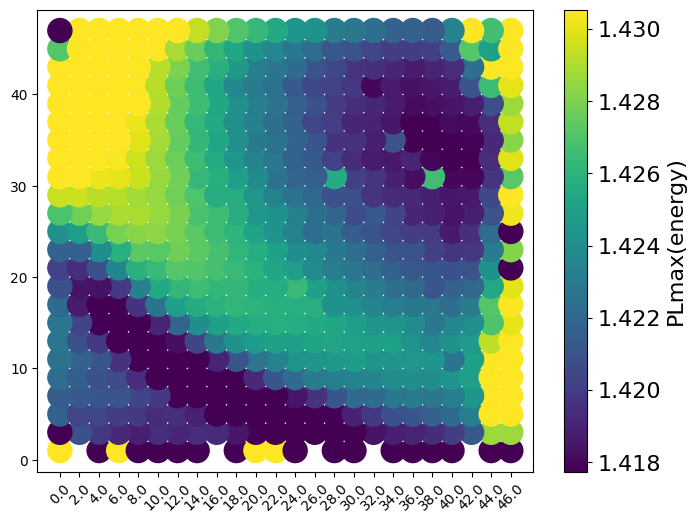

In [20]:
#Plotting coordinates and PL peak, PLQY
#here, coordinates are reversed in PLQY and PL.
#%matplotlib notebook

def plot_data():
    x_coords = np.array(peak_data['x'])
    y_coords = np.array(peak_data['y'])
    pl_peak_x = np.array(peak_data['peak_pos'])
    
    fig, ax= plt.subplots(figsize=(8, 6))
    
    # todo why x_coords need to reverse, y_coords does not need to ?
    Q1 = peak_data['peak_pos'].quantile(0.1)
    Q2 = peak_data['peak_pos'].quantile(0.9)
    
    scatter=ax.scatter(x_coords[::-1],y_coords, c=pl_peak_x[::-1], marker='o', cmap='viridis', s=300, vmin=Q1, vmax=Q2)
    cbar = plt.colorbar(scatter, ax=ax)
    #cbar.set_label('PLQY', fontsize=16)
    cbar.set_label('PLmax(energy)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.xticks(rotation=45)
   
    plt.show()
    #fig.savefig(r'D:\CsSnIBr0.3\PLmaps\4025-14\4025-14-PL_peak.png', dpi=500, bbox_inches='tight', transparent="True", pad_inches=0)

plot_data() ##use peak_positions_df or integral_pl to visualize pl peak & plqy
#plot_data(integral_pl)

## save as pixel archive.json

In [34]:
from nomad.datamodel import EntryArchive
from nomad.datamodel import EntryMetadata
from hzb_combinatorial_libraries.schema import Pixel
from hzb_combinatorial_libraries.schema import PixelProperty
from nomad_material_processing.combinatorial import CombinatorialSamplePosition

import json

for i in range(2, len(df)):
    plqy = df.loc[i, 'integral_pl']
    voc = df.loc[i, 'voc']
    fwhm = df.loc[i, 'FWHM']
    x = df.loc[i, 'x']
    y = df.loc[i, 'y']
    pos = CombinatorialSamplePosition(x=x, y=y)

    # if not plqy.isinstance(value, float):
    #     print(plqy)
    
    pixel_property = PixelProperty(PLQY=plqy, implied_voc=voc, FWHM=fwhm)
    pixel = Pixel(properties=pixel_property)
    
    data = {}
    archive = EntryArchive(metadata=EntryMetadata())
    archive.data = pixel
    archive.data.position = CombinatorialSamplePosition(x=x, y=y)
    archive.data.lab_id = lab_id

    # normalize_all(archive)

    json_data = archive.m_to_dict()
    json_data['data']['m_def'] = "hzb_combinatorial_libraries.schema.Pixel" 

    import json
    # JSON(archive.m_to_dict())
    
    temp_filename = f'temp_{i}.archive.json'
    with open(temp_filename, 'w') as f:
            json.dump(json_data, f, indent=2)
    
    if i == 5:
        import pandas as pd  # Import pandas to access the 'df' variable

        # Define or import the 'df' variable here

        # Rest of the code...
        break
       # Add the temporary file to the zip
        zipf.write(temp_filename, arcname=f'tadfm_{file_counter}.archive.json')

        # Remove the temporary file
        os.remove(temp_filename)
